In [ ]:
import math
import copy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid

# Back-propagación

Original: https://github.com/romaintha/backpropagation/blob/master/Backpropagation.ipynb

## Contexto

Con la democratización del aprendizaje profundo y la introducción de herramientas de código abierto como Tensorflow o Keras, hoy en día se puede entrenar [una red neuronal convolucional para clasificar imágenes de perros y gatos con poco conocimiento sobre Python](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb).

Desafortunadamente, estas herramientas tienden a abstraernos la parte difícil, y entonces nos vemos tentados a omitir la comprensión de la mecánica interna. En particular, no comprender la retropropagación, el pan de cada día del aprendizaje profundo, lo más probable es que te lleve a diseñar mal tus redes. En un [artículo de Medium](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b), Andrej Karpathy enumeró algunas razones por las que deberías comprender la retropropagación. Problemas como la desaparición y explosión de gradientes o la muerte de relus son algunos de ellos. 

La retropropagación no es un algoritmo muy complicado y, con algunos conocimientos de cálculo, especialmente sobre las reglas de la cadena, se puede entender bastante rápido.


Las redes neuronales, como cualquier otro algoritmo de aprendizaje supervisado, aprenden a mapear una entrada a una salida basándose en algunos ejemplos proporcionados de pares (entrada, salida), llamados el conjunto de entrenamiento. En particular, las redes neuronales realizan este mapeo procesando la entrada a través de un conjunto de transformaciones. Una red neuronal se compone de varias capas, y cada una de estas capas está formada por unidades (también llamadas neuronas) como se ilustra a continuación:

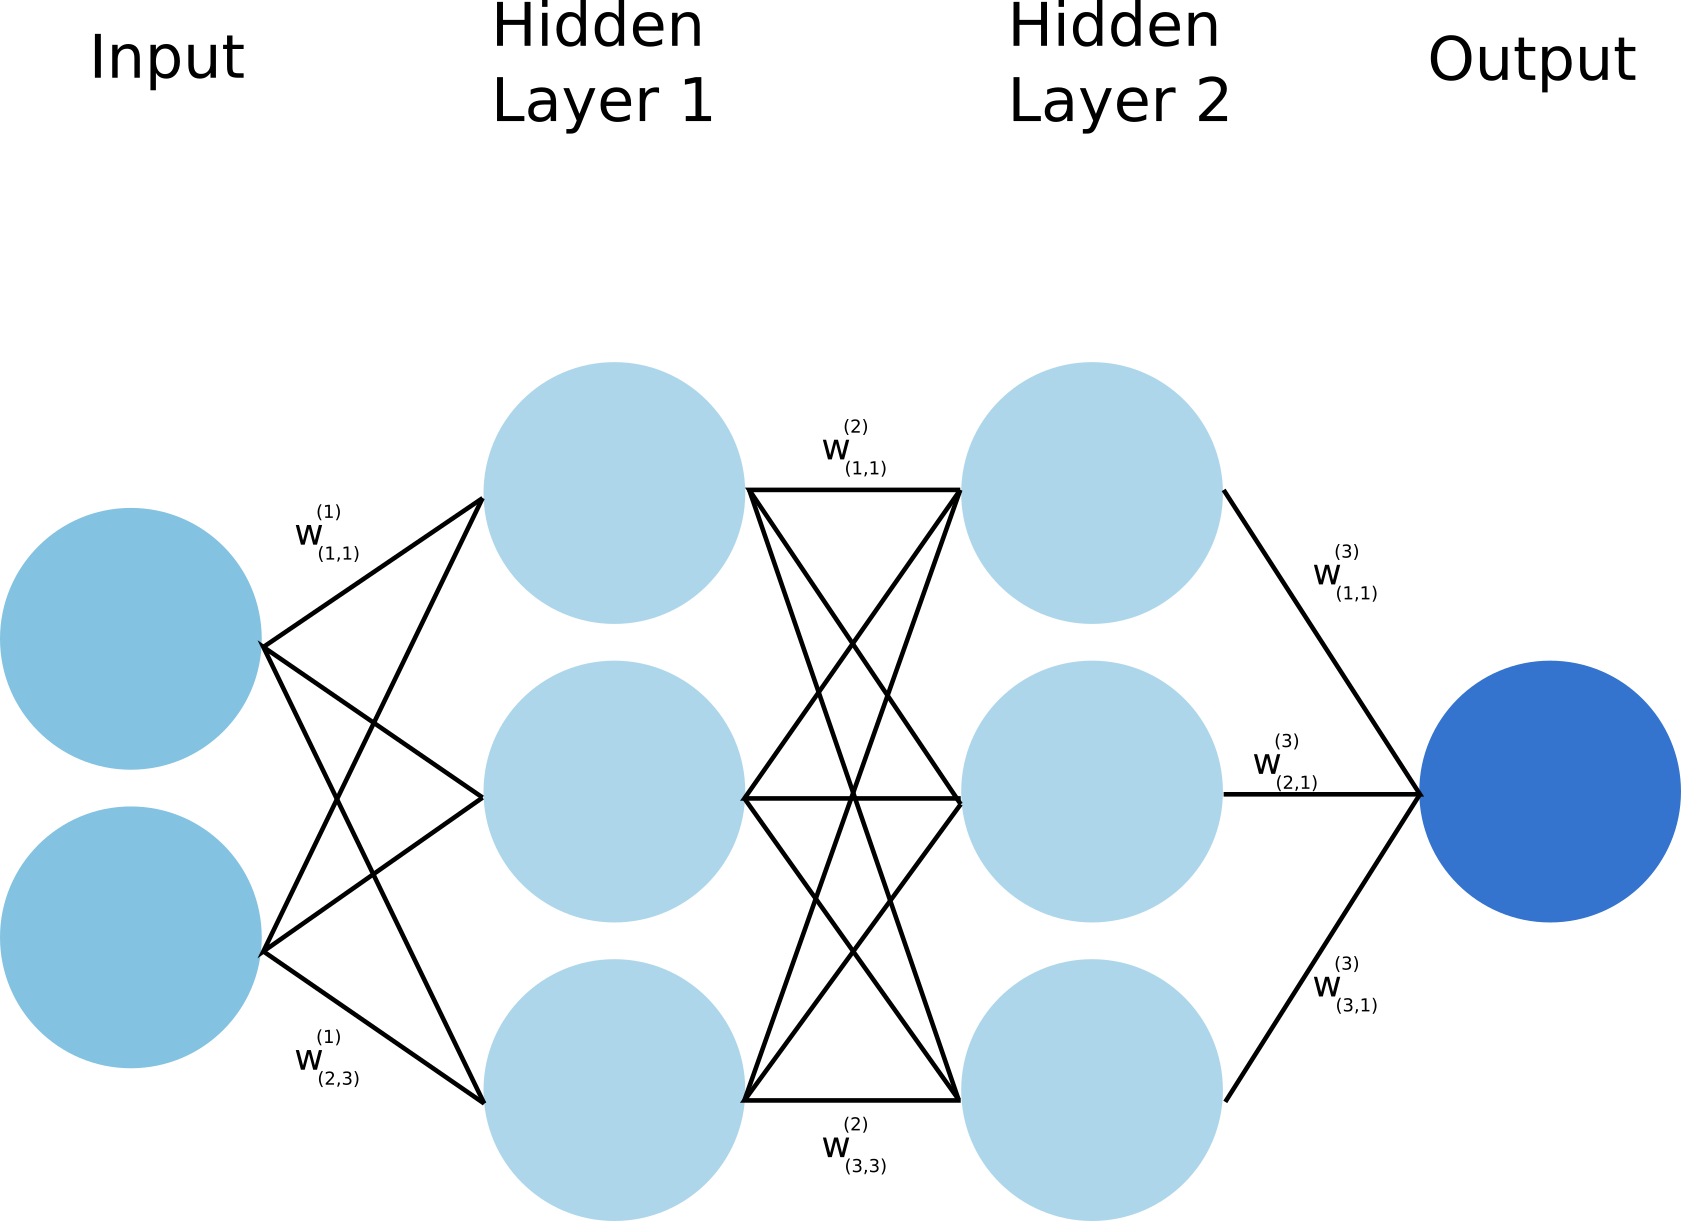

En la imagen de arriba, la entrada se transforma primero a través de la capa oculta 1, luego la segunda y finalmente se predice una salida. Cada transformación está controlada por un conjunto de pesos (y sesgos o *biases*). Durante el entrenamiento, para aprender algo, la red necesita ajustar estos pesos para minimizar el error (también llamado *función de pérdida*) entre las salidas esperadas y las que asigna a partir de las entradas dadas. Usando el [descenso de gradiente](https://en.wikipedia.org/wiki/Gradient_descent) como algoritmo de optimización, los pesos se actualizan en cada iteración como:

$ w^{(n+1)} = w^{(n)} - \epsilon \frac{\partial L}{\partial w} $, donde $L$ es la función de pérdida y $\epsilon$ es la tasa de aprendizaje.

Como podemos ver arriba, el gradiente de la pérdida con respecto al peso se resta del peso en cada iteración. Esto es lo que se llama descenso de gradiente. El gradiente $\frac{\partial L}{\partial w} $ se puede interpretar como una medida de la contribución del peso a la pérdida. Por lo tanto, cuanto mayor sea este gradiente (en valor absoluto), más se actualiza el peso durante una iteración de descenso de gradiente.

La tarea de minimización de la función de pérdida termina estando relacionada con la evaluación de los gradientes descrita anteriormente. Revisaremos 3 propuestas para realizar esta evaluación:

- Cálculo analítico de los gradientes.
- Aproximación de los gradientes como: $ \frac{\partial L}{\partial w} = \frac{L(w + \delta w) - L(w)}{\delta w}$, donde $\delta w \rightarrow 0$.
- Retropropagación o autodiff en modo inverso.

## Definición del problema

Analicemos un poco cómo se transforma la entrada para producir la representación de la capa oculta. En una red neuronal, una capa se obtiene realizando dos operaciones sobre la capa anterior:

- En primer lugar, la capa anterior se transforma mediante una operación lineal: el valor de la capa anterior se multiplica por un peso y se le añade un sesgo. Esto da como resultado: $z = xw + b$, donde $x$ es el valor de la unidad de la capa anterior, $w$ y $b$ son respectivamente el peso y el sesgo discutidos anteriormente.

- En segundo lugar, la operación lineal anterior se utiliza como entrada a la función de activación de la unidad. Esta activación se elige generalmente para introducir no linealidad con el fin de resolver tareas complejas. Aquí simplemente consideraremos que esta función de activación es una función sigmoidea: $\sigma(x) = \frac{1}{1+\exp(-x)}$. Como consecuencia, el valor $y$ de una capa se puede escribir como: $y=\sigma(z)=\sigma(xw+b)$.

Con una capa de entrada, una capa oculta y una capa de salida, todas formadas por una sola unidad y llamadas respectivamente $x$, $h$ e $y$, podemos escribir:

$ h = \sigma (xw_1 + b_1) $, donde $w_1$ y $b_1$ son respectivamente el peso y el sesgo utilizados para calcular la unidad oculta a partir de la entrada.

$ y = \sigma (hw_2 + b_2) $, donde $w_2$ y $b_2$ son respectivamente el peso y el sesgo utilizados para calcular la salida de la unidad oculta.

A partir de ahora, podemos calcular la salida $y$ en función de la entrada $x$, mediante un conjunto de transformaciones. Esto se denomina *propagación hacia adelante*, ya que este cálculo se realiza hacia adelante dentro de la red.

Ahora debemos comparar este resultado predicho con el verdadero $y_T$. Como se explicó anteriormente, utilizamos una función de pérdida para cuantificar el error que comete la red al predecir. Aquí consideraremos como función de pérdida el error al cuadrado definido como:

$ L = \frac{1}{2} (y-y_T)^2 $

Como se mencionó anteriormente, los pesos (y sesgos) deben actualizarse de acuerdo con el gradiente de esta función de pérdida L con respecto a estos pesos (y sesgos). Por lo tanto, el desafío aquí es evaluar estos gradientes. El primer enfoque sería derivarlos manualmente.

## Derivación analítica

Aunque este método es complicado y propenso a errores, vale la pena investigarlo para comprender mejor el desafío. Aquí simplificamos mucho el problema ya que tenemos una sola capa oculta y una sola unidad por capa. Y, sin embargo, la derivación analítica requiere bastante atención.

\begin{equation}
    \begin{split}
    \frac{\partial L}{\partial w_2} & = \frac{1}{2} \frac{\partial \left((y-y_T)^2\right)}{\partial w_2} \\
                                    & = \frac{1}{2} \left(\frac{\partial \left(y^2\right)}{\partial w_2} - 2y_T \frac{\partial y}{\partial w_2}\right)\\\       \end{split}
\end{equation}

Sabiendo que $y = \sigma (hw_2 + b_2) $, obtenemos:

\begin{equation} 
    \begin{split}
        \frac{\partial L}{\partial w_2} & = \frac{1}{2} \left(\frac{\partial \left(\frac{1}{\left( 1 + \exp(-hw_2 -b_2\right))^2}\right)}{\partial w_2} - 2y_T \frac{\partial \frac{1}{1 + \exp(-hw_2 - b_2)}}{\partial w_2}\right) \\
                                        & = \frac{h \exp(-hw_2 - b_2)}{\left(1+\exp(-hw_2 - b_2)\right)^3} - \frac{y_T h \exp(-hw_2 - b_2)}{\left(1+\exp(-hw_2 - b_2)\right)^2} \\
                                        & = h\frac{ \exp(-hw_2 - b_2)}{\left(1+\exp(-hw_2 - b_2)\right)^2} \left(\frac{1}{1+\exp(-hw_2 - b_2)} - y_T\right)
    \end{split}
\end{equation}

Aquí derivamos el gradiente con respecto a $w_2$, y el cálculo para el que se refiere a $w_1$ sería aún más tedioso. Por lo tanto, un enfoque analítico de este tipo sería muy difícil de implementar para una red compleja. Además, en términos de cálculo, este enfoque sería bastante ineficiente ya que no podríamos aprovechar el hecho de que los gradientes comparten una definición común, como veremos pronto. Una forma mucho más sencilla de obtener estos gradientes sería utilizar una aproximación numérica.

## Derivación numérica

Cambiando la precisión por la simplicidad, podemos obtener el gradiente utilizando lo siguiente:

\begin{equation} 
    \begin{split}
        \frac{\partial L}{\partial w} \simeq \frac{L(w + \delta w) - L(w)}{\delta w}, \space with \space\delta w \rightarrow 0
    \end{split}
\end{equation}

Como se sugirió anteriormente, aunque más simple que la derivación analítica, esta diferenciación numérica también es menos precisa. Además, para cada gradiente a evaluar, tendríamos que calcular la función de pérdida al menos una vez (haciendo un pase hacia adelante por pesos y sesgos). Para una red neuronal con 1 millón de parámetros de peso, se requerirían 1 millón de pases hacia adelante, lo que definitivamente no es eficiente de calcular. Ahora veamos una mejor solución y el núcleo de este artículo revisando el enfoque de retropropagación.


# Back-propagación

Antes de hablar con más detalle sobre qué es la retropropagación, introduzcamos primero el gráfico computacional que conduce a la evaluación de la función de pérdida.

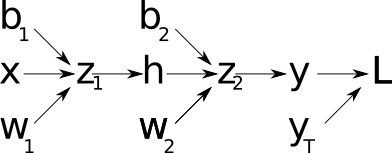

Los nodos de este gráfico corresponden a todos los valores que se calculan para obtener la pérdida L. Si se calcula una variable aplicando una operación a otra variable, se dibuja una arista entre los dos nodos de la variable. Observando este gráfico y haciendo uso de la regla de la cadena del cálculo, podemos expresar el gradiente de L con respecto a los pesos (o sesgos) como:

\begin{equation} 
    \begin{split}
        \frac{\partial L}{\partial w_2} & = \frac{\partial L}{\partial y} \frac{\partial y}{\partial w_2}\\
                                        & = \frac{\partial L}{\partial y} \frac{\partial y}{\partial z_2} \frac{\partial z_2}{\partial w_2} \\
    \end{split}
\end{equation}

Lo mismo ocurre con el peso $ w_1 $:

\begin{equation} 
    \begin{split}
        \frac{\partial L}{\partial w_1} & = \frac{\partial L}{\partial y} \frac{\partial y}{\partial w_1}\\
                                        & = \frac{\partial L}{\partial y} \frac{\partial y}{\partial z_2} \frac{\partial z_2}{\partial w_1} \\
                                        & = \frac{\partial L}{\partial y} \frac{\partial y}{\partial z_2} \frac{\partial z_2}{\partial h} \frac{\partial h}{\partial w_1} \\
                                        & = \frac{\partial L}{\partial y} \frac{\partial y}{\partial z_2} \frac{\partial z_2}{\partial h} \frac{\partial h}{\partial z_1} \frac{\partial z_1}{\partial w_1}
    \end{split}
\end{equation}

Una cosa muy importante a tener en cuenta aquí es que la evaluación del gradiente $\frac{\partial L}{\partial w_1}$ puede reutilizar algunos de los cálculos realizados durante la evaluación del gradiente $\frac{\partial L}{\partial w_2}$. Es aún más claro si evaluamos el gradiente $\frac{\partial L}{\partial b_1}$:

\begin{equation} 
    \begin{split}
        \frac{\partial L}{\partial b_1} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial z_2} \frac{\partial z_2}{\partial h} \frac{\partial h}{\partial z_1} \frac{\partial z_1}{\partial b_1}
    \end{split}
\end{equation}

Vemos que los primeros cuatro términos del lado derecho de la ecuación son los mismos que el de $\frac{\partial F}{\partial w_ 1}$.

Como se puede ver en las ecuaciones anteriores, calculamos el gradiente a partir del final del gráfico computacional y procedemos hacia atrás para obtener el gradiente de la pérdida con respecto a los pesos (o los sesgos). Esta evaluación hacia atrás da nombre al algoritmo: retropropagación. El algoritmo de retropropagación se puede ilustrar con la siguiente imagen:

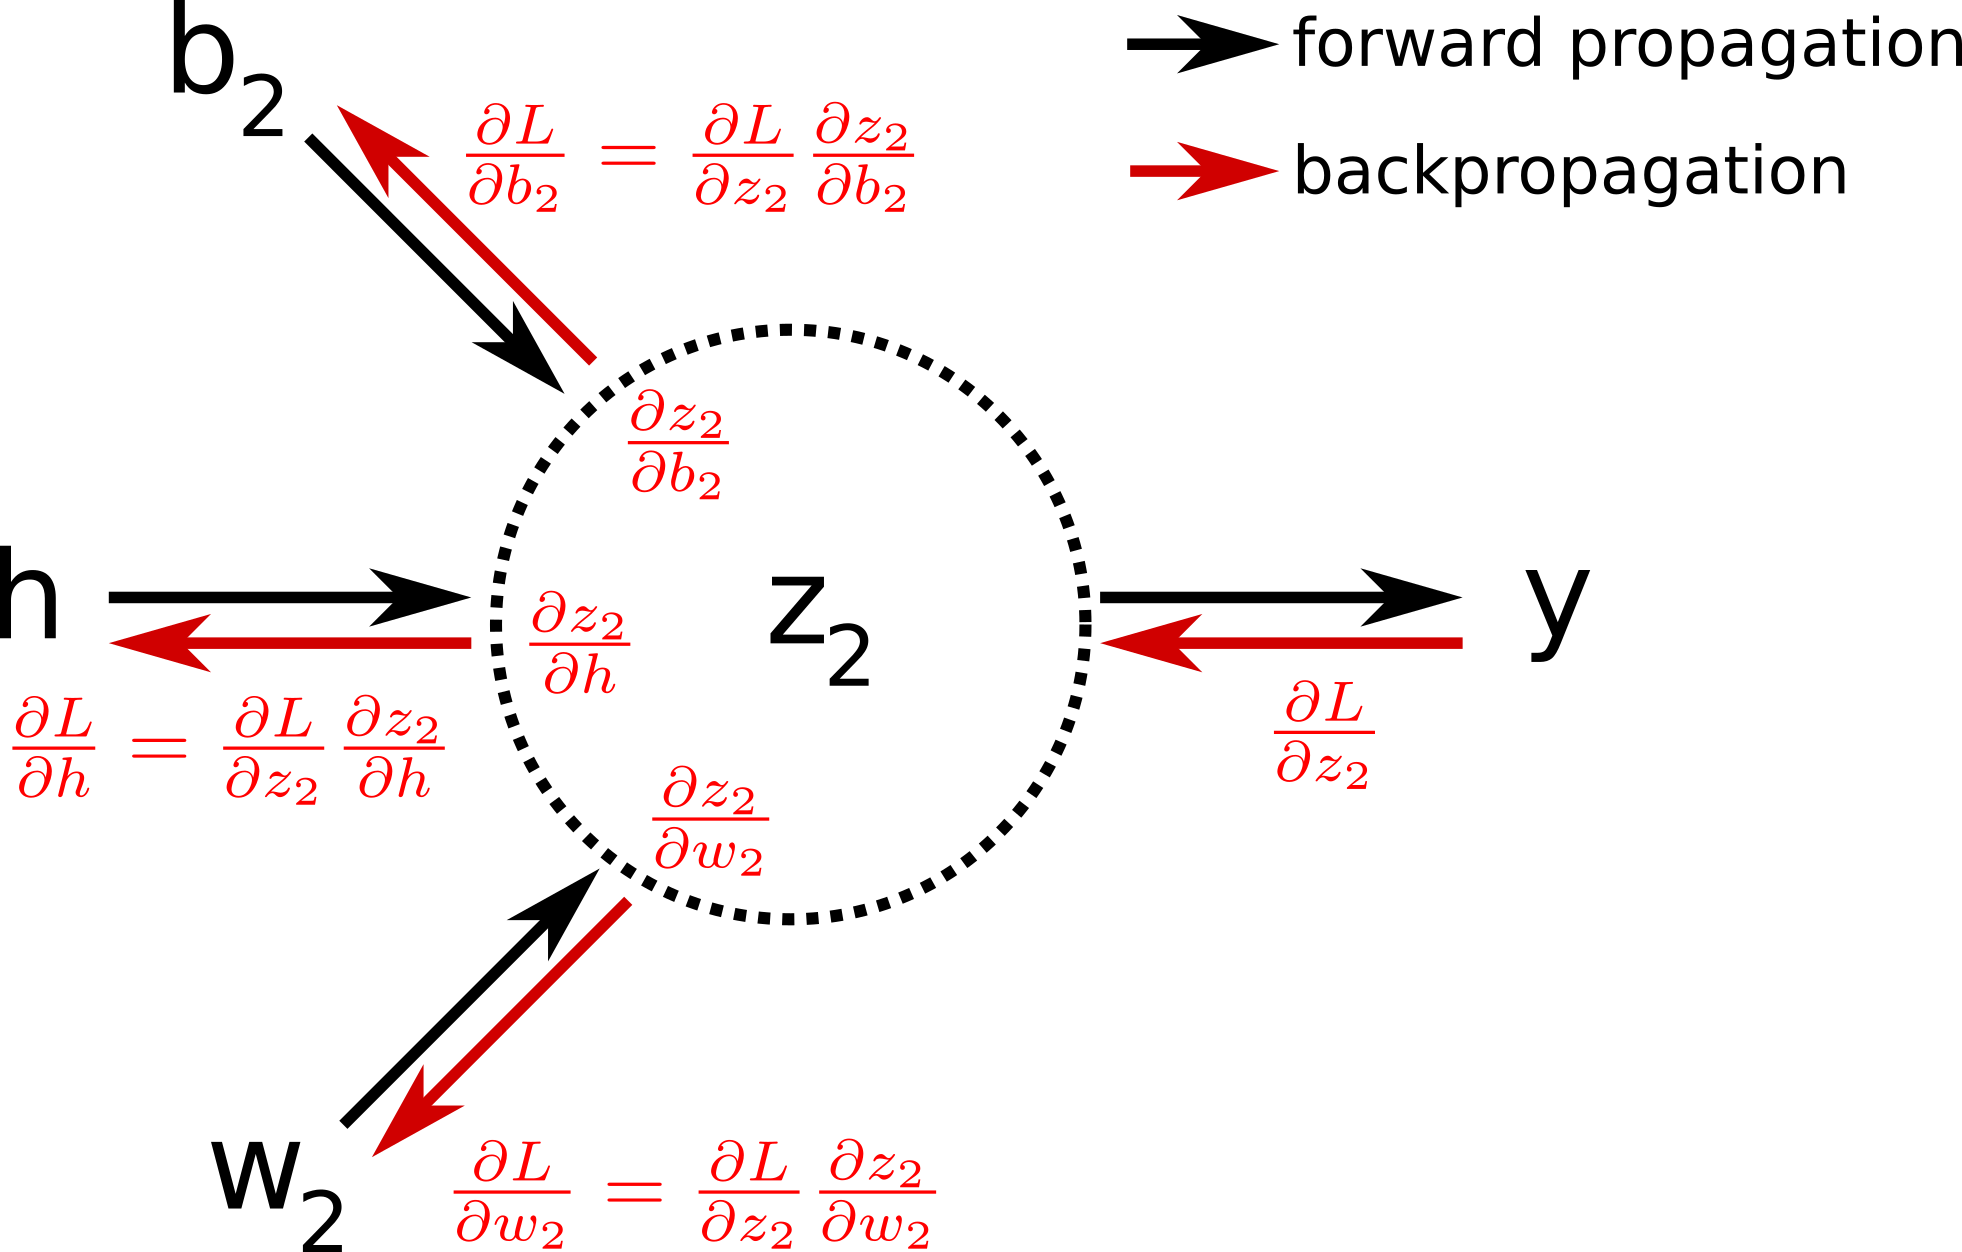

En la práctica, una iteración del descenso de gradiente requeriría ahora un paso hacia adelante y solo un paso en la dirección inversa para calcular todas las derivadas parciales a partir del nodo de salida. Por lo tanto, es mucho más eficiente que los enfoques anteriores. En el artículo original sobre retropropagación publicado en 1986, los autores (entre los que se encontraba Geoffrey Hinton) utilizaron por primera vez la retropropagación para permitir que las unidades ocultas internas aprendieran características del dominio de la tarea.

Para visualizar mejor lo que es la retropropagación en la práctica, implementemos un problema de clasificación de redes neuronales en numpy. De hecho, como veremos a continuación, no es necesario contar con una biblioteca de aprendizaje profundo compleja para jugar primero con una red neuronal.